#### CANB8347 Machine Learning Project
Given annotated dataset, develop a supervised machine learning method to predict live births from multi-dimensional data

In [42]:
import numpy as np
import pandas as pd
import scipy as sc

# sklearn tools
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# plotting tools
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'white')
%matplotlib inline

---
#### 0. read in dataset and look at feature labels

In [2]:
vlbw = pd.read_csv('data/vlbw_train.csv')

In [3]:
vlbw.drop('Unnamed: 0', axis=1, inplace=True) # get rid of index axis
# look at number of missing observations in each feature
vlbw.isnull().sum()

birth        19
exit         27
hospstay     27
lowph        50
pltct        57
race         20
bwt           2
gest          2
inout         1
twn          18
lol         306
magsulf     200
meth         88
toc          88
delivery     21
apg1         29
vent         24
pneumo       21
pda          23
cld          56
pvh         121
ivh         120
ipe         120
year         19
sex          19
dead          0
dtype: int64


Features with a lot of missing observations are concerning:
* lol
* magsulf
* meth
* toc
* pvh
* ivh
* ipe

---
#### Investigate missing values and decide how to impute/what to keep

In [4]:
# for all the numeric, continuous data, see if the features correlate with live births
print('lol: {}'.format(vlbw.lol.corr(vlbw.dead)))
print('magsulf: {}'.format(vlbw.magsulf.corr(vlbw.dead)))
print('meth: {}'.format(vlbw.meth.corr(vlbw.dead)))
print('toc: {}'.format(vlbw.toc.corr(vlbw.dead)))

lol: 0.16361321302009335
magsulf: -0.06183780159526858
meth: -0.1651503386980673
toc: 0.010423079240993036


In [5]:
# add labor length of 0 for any abdominal births without any value already assigned
vlbw.loc[(vlbw.delivery=='abdominal') & (vlbw.lol.isnull()), 'lol'] = 0

In [6]:
vlbw.magsulf.value_counts()

0.0    292
1.0     45
Name: magsulf, dtype: int64

In [7]:
# this one's probably okay to impute zero for the missing values
vlbw.loc[vlbw.magsulf.isnull(), 'magsulf'] = 0

In [8]:
vlbw.meth.value_counts()

0.0    254
1.0    195
Name: meth, dtype: int64

In [9]:
# again, for 88 observations with a low correlation to death, 
# this one's probably okay to impute zero for the missing values
vlbw.loc[vlbw.meth.isnull(), 'meth'] = 0

In [10]:
vlbw.toc.value_counts()

0.0    347
1.0    102
Name: toc, dtype: int64

In [11]:
# again, for 88 observations with a low correlation to death, 
# this one's probably okay to impute zero for the missing values
vlbw.loc[vlbw.toc.isnull(), 'toc'] = 0

---
#### Devise scheme for numerizing categorical data
Start with `pvh`, `ivh`, and `ipe`, which are missing a bunch of values and have more than two levels.

In [13]:
# see potential 'pvh' values and their counts
vlbw.pvh.value_counts()

absent      283
definite    102
possible     31
Name: pvh, dtype: int64

In [14]:
# replace categories with numeric levels based on confidence of pvh diagnosis
vlbw.loc[vlbw.pvh=='absent', 'pvh'] = 0
vlbw.loc[vlbw.pvh=='possible', 'pvh'] = 1
vlbw.loc[vlbw.pvh=='definite', 'pvh'] = 2

In [15]:
# now levels should be 0, 1, 2
vlbw.pvh.value_counts()

0    283
2    102
1     31
Name: pvh, dtype: int64

In [16]:
# correlate death to new numeric pvh values
vlbw.dead.corr(vlbw.pvh.astype('float'))

0.13088756681400213

Kinda significant correlation here.  Do the same for IVH and IPE.

In [17]:
# see potential 'ivh' values and counts
vlbw.ivh.value_counts()

absent      351
definite     58
possible      8
Name: ivh, dtype: int64

In [18]:
# replace categories with numeric levels based on confidence of pvh diagnosis
vlbw.loc[vlbw.ivh=='absent', 'ivh'] = 0
vlbw.loc[vlbw.ivh=='possible', 'ivh'] = 1
vlbw.loc[vlbw.ivh=='definite', 'ivh'] = 2

In [19]:
# now levels should be 0, 1, 2
vlbw.ivh.value_counts()

0    351
2     58
1      8
Name: ivh, dtype: int64

In [20]:
# correlate death to new numeric pvh values
vlbw.dead.corr(vlbw.ivh.astype('float'))

0.3742851724990472

That's a large correlation too.

In [21]:
# see how many of each category
vlbw.ipe.value_counts()

absent      374
definite     29
possible     14
Name: ipe, dtype: int64

In [22]:
# replace categories with numeric levels based on confidence of pvh diagnosis
vlbw.loc[vlbw.ipe=='absent', 'ipe'] = 0
vlbw.loc[vlbw.ipe=='possible', 'ipe'] = 1
vlbw.loc[vlbw.ipe=='definite', 'ipe'] = 2

In [23]:
# now levels should be 0, 1, 2
vlbw.ipe.value_counts()

0    374
2     29
1     14
Name: ipe, dtype: int64

In [24]:
# correlate death to new numeric pvh values
vlbw.dead.corr(vlbw.ipe.astype('float'))

0.1210600680990267

Smaller for IPE, but still there

Now the problem with these values (`pvh`, `ivh`, `ipe`) will be imputation.  How do we impute 120 values in a dataset of 500?  Random sampling introduces noise, but assuming absence could also yield false negatives.

In [25]:
# make sure the columns are numeric datatype before moving on
vlbw.loc[:,'pvh'] = vlbw.pvh.astype('float64', inplace=True)
vlbw.loc[:,'ivh'] = vlbw.ivh.astype('float64', inplace=True)
vlbw.loc[:,'ipe'] = vlbw.ipe.astype('float64', inplace=True)

---
#### Check out other categorical variables and see how to convert to numeric

In [26]:
# features that are still categorical
vlbw.dtypes[vlbw.dtypes=='object']

race        object
inout       object
delivery    object
sex         object
dtype: object

In [27]:
vlbw.race.value_counts()

black              305
white              196
native American     13
oriental             3
Name: race, dtype: int64

In [28]:
vlbw.inout.value_counts()

born at Duke    437
transported      99
Name: inout, dtype: int64

In [29]:
vlbw.delivery.value_counts()

vaginal      271
abdominal    245
Name: delivery, dtype: int64

In [30]:
vlbw.sex.value_counts()

male      262
female    256
Name: sex, dtype: int64

In [31]:
def numerize(df, col, drop=True):
    '''
    make categorical data numeric from 0 - n categories
        df = dataframe
        col = column to numerize into n_categories columns
        drop = drop original column or retain in df?
    '''
    temp = df.copy(deep=True) # copy df so you don't affect it
    
    for cat in temp[col].unique():
        # for each categorical value, create a new column with binary values for T/F
        temp[col+'_'+str(cat)] = (temp[col]==cat)*1
        
    if drop:
        return temp.drop(col, axis=1)
    
    else:
        return temp

In [32]:
# perform numerization on whole dataset
for feature, datatype in zip(vlbw.dtypes.index, vlbw.dtypes):
    if datatype == 'object':
        vlbw = numerize(vlbw, feature)

In [33]:
# look at resulting features
# should be more than we started with, as data is now in long-form
vlbw.dtypes

birth                   float64
exit                    float64
hospstay                float64
lowph                   float64
pltct                   float64
bwt                     float64
gest                    float64
twn                     float64
lol                     float64
magsulf                 float64
meth                    float64
toc                     float64
apg1                    float64
vent                    float64
pneumo                  float64
pda                     float64
cld                     float64
pvh                     float64
ivh                     float64
ipe                     float64
year                    float64
dead                      int64
race_white                int64
race_black                int64
race_nan                  int64
race_native American      int64
race_oriental             int64
inout_born at Duke        int64
inout_transported         int64
inout_nan                 int64
delivery_abdominal        int64
delivery

In [34]:
# save the 'numerified' data as .csv file
vlbw.to_csv('data/vlbw_train_numeric.csv', index=False)

---
#### 2. impute missing values with mode of each feature
might not be the best strategy for dealing with `NaN`s, but let's just see how a PCA looks 

In [40]:
# look at features with high number of missing observations (~>10% of total observations)
vlbw.isnull().sum()[vlbw.isnull().sum()>55]

pltct     57
lol      182
cld       56
pvh      121
ivh      120
ipe      120
dtype: int64

In [43]:
# fill NaNs with mode value of each column
vlbw_filled = SimpleImputer(strategy='most_frequent').fit_transform(vlbw)

In [44]:
# normalize each column to fractional representation between 0 and 1
vlbw_filled_norm = normalize(vlbw_filled, axis=1, norm='l1')

---
#### 3. look at principal components and see where highest explained variance lies

In [45]:
# perform principal component analysis on entire imputed dataset
vlbw_PCA_fit = PCA(n_components=5).fit(vlbw_filled_norm)
vlbw_PCA = vlbw_PCA_fit.transform(vlbw_filled_norm)

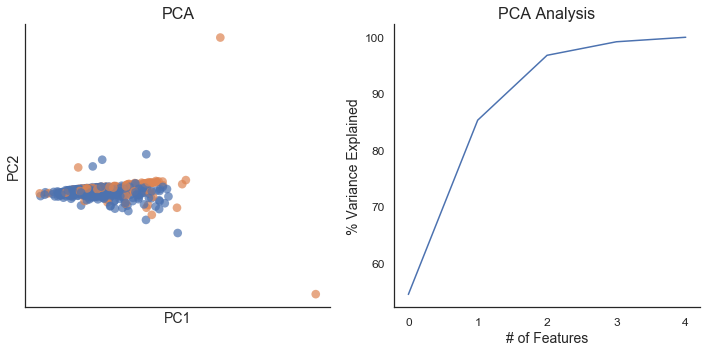

In [46]:
# plot PCA results for first two PCs, colored by desired label (live birth)
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(x=vlbw_PCA[:,0], y=vlbw_PCA[:,1], s=75, alpha=0.7, hue=vlbw['dead'], legend=None, edgecolor='none')
plt.tick_params(labelbottom=False, labelleft=False)
plt.ylabel('PC2', fontsize=14)
plt.xlabel('PC1', fontsize=14)
plt.title('PCA', fontsize=16)

plt.subplot(122)
plt.plot(np.cumsum(np.round(vlbw_PCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.tick_params(labelsize=12)
plt.ylabel('% Variance Explained', fontsize=14)
plt.xlabel('# of Features', fontsize=14)
plt.title('PCA Analysis', fontsize=16)

sns.despine()
plt.tight_layout()
plt.show()

In [47]:
# we can extract the contribution of each feature to each PC
PCfeatures = pd.DataFrame(vlbw_PCA_fit.components_, columns=vlbw.columns)
# look at top 10 features that contribute to PC1, in descending order
PCfeatures.iloc[0,:].rank().sort_values()

bwt                      1.0
delivery_abdominal       2.0
race_white               3.0
twn                      4.0
meth                     5.0
race_native American     6.0
sex_nan                  8.5
delivery_nan             8.5
inout_nan                8.5
race_nan                 8.5
race_oriental           11.0
magsulf                 12.0
toc                     13.0
inout_transported       14.0
sex_female              15.0
pneumo                  16.0
sex_male                17.0
ipe                     18.0
pda                     19.0
ivh                     20.0
pvh                     21.0
inout_born at Duke      22.0
race_black              23.0
delivery_vaginal        24.0
cld                     25.0
dead                    26.0
apg1                    27.0
vent                    28.0
lowph                   29.0
gest                    30.0
lol                     31.0
exit                    32.0
birth                   33.0
year                    34.0
hospstay      

Looks like birthweight and abdominal delivery are the two largest contributors to live birth from this dataset.  

---
Next steps to try:
* eliminate 'noisy' features with low contributions to first few PCs
* think about other ways to eliminate or impute `NaN` values - this was just a first-pass
* start researching [supervised approaches](https://scikit-learn.org/stable/supervised_learning.html) to start fitting to this dataset 